In [1]:
%load_ext autotime
%load_ext autoreload 
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
from joblib import dump, load
import graphviz 

from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix

# sys.path.append('./src/')
from config import *
from utils import *
from visualization import *

time: 2.27 s (started: 2023-04-09 18:47:55 +08:00)


In [2]:
input_path = os.path.join(DATA_DIR, 'train')
points_path = os.path.join(DATA_DIR, 'train', 'points')

data = {}
for label in labels:
    curr_data = {}
    img_files = [f for f in os.listdir(os.path.join(input_path, label)) if '.jpg' in f]
    for i, f in enumerate(img_files):
        pt_path = os.path.join(points_path, f.replace('.jpg', '.npy'))
        curr_data.update({f:np.loadtxt(pt_path)})
    print(i+1, 'files retrived for class', label.upper())
    data.update({label:curr_data})

284 files retrived for class NORMAL
71 files retrived for class ALERT
time: 468 ms (started: 2023-04-09 18:47:58 +08:00)


In [3]:
print(KEYPOINT_DICT)

{'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4, 'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8, 'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12, 'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16}
time: 187 ms (started: 2023-04-09 18:47:58 +08:00)


In [4]:
df = []
for sample_label in labels:
    for sample_file in data[sample_label]:
        keypoints_with_scores = data[sample_label][sample_file]
        curr_features = produce_feature(keypoints_with_scores, return_dict=True)
        training_data = {'label':sample_label, 'file_name':sample_file}
        training_data.update(curr_features)
        df.append(training_data)
df = pd.DataFrame(df).sort_values('file_name', ascending=True).reset_index(drop=True)

# Using previous data when possible, if center cannot be identified
# 'head_center_y', 'body_center_y', 'foot_center_y'
default_val = 0
for i in range(df.shape[0]):
    if i == 0 or int(df.iloc[i, 1].split('.')[0]) - int(df.iloc[i-1, 1].split('.')[0])  < 10**6:
        for c in range(2, 5):
            if df.iloc[i, c] != df.iloc[i, c]:
                df.iloc[i, c] = default_val       
    else:  
        for c in range(2, 5):
            if df.iloc[i, c] != df.iloc[i, c]:
                df.iloc[i, c] = df.iloc[i-1, c]   

df['head_above_body'] = df['head_center_y'] > df['body_center_y']
df['head_below_body'] = df['head_center_y'] < df['body_center_y']
df['body_above_foot'] = df['body_center_y'] > df['foot_center_y']
df['body_below_foot'] = df['body_center_y'] < df['foot_center_y']
df['head_above_foot'] = df['head_center_y'] > df['foot_center_y']
df['head_below_foot'] = df['head_center_y'] < df['foot_center_y']

features = ['head_center_y', 'body_center_y', 'foot_center_y', 'num_detection',
            'head_above_body', 'head_below_body', 'body_above_foot', 
            'body_below_foot', 'head_above_foot', 'head_below_foot']

time: 281 ms (started: 2023-04-09 18:47:58 +08:00)


In [5]:
df

,label,file_name,head_center_y,body_center_y,foot_center_y,num_detection,head_above_body,head_below_body,body_above_foot,body_below_foot,head_above_foot,head_below_foot
0,normal,20230408113742800161.jpg,0.981448,0.000000,0.000000,1,True,False,False,False,True,False
1,normal,20230408113743848244.jpg,0.981448,0.000000,0.000000,0,True,False,False,False,True,False
2,normal,20230408113744657076.jpg,0.000000,0.000000,0.000000,0,False,False,False,False,False,False
3,normal,20230408113745493582.jpg,0.000000,0.000000,0.000000,0,False,False,False,False,False,False
4,normal,20230408113746395248.jpg,0.000000,0.000000,0.000000,0,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
350,alert,20230408170438597847.jpg,0.737078,0.749507,0.000000,9,False,True,True,False,True,False
351,alert,20230408170439456369.jpg,0.000000,0.000000,0.000000,0,False,False,False,False,False,False
352,alert,20230408170440319791.jpg,0.724183,0.711388,0.771365,14,True,False,False,True,False,True
353,alert,20230408170441186098.jpg,0.591780,0.693862,0.731202,16,False,True,False,True,False,True


time: 172 ms (started: 2023-04-09 18:47:59 +08:00)


In [6]:
# Class imbalance: produce more of 'alert' data
class1, class2 = df['label'].value_counts().sort_index().values
if int(class2 / class1) > 2:
    df = pd.concat([df] + [df[df['label']=='alert']]*int(class2 / class1))
df['label'].value_counts()

alert     355
normal    284
Name: label, dtype: int64

time: 187 ms (started: 2023-04-09 18:47:59 +08:00)


In [7]:
# If no points detected, force the classifier to detect 'normal'
mask = df[features].sum(axis=1) == 0
mask1 = df['label'] == 'normal'
class1_zero, class2_zero = df[mask]['label'].value_counts().sort_index().values
if class1_zero > class2_zero:
    df = pd.concat([df] + [df[mask & mask1]]*(int(class1_zero / class2_zero)+1))

mask = df[features].sum(axis=1) == 0
print('No points detected')
df[mask]['label'].value_counts().sort_index()

No points detected


alert     55
normal    90
Name: label, dtype: int64

time: 203 ms (started: 2023-04-09 18:47:59 +08:00)


In [8]:
print('Overall')
df['label'].value_counts().sort_index()

Overall


alert     355
normal    356
Name: label, dtype: int64

time: 187 ms (started: 2023-04-09 18:47:59 +08:00)


In [10]:
train, test = df[features].values, df['label'].values
rng = np.random.RandomState(10)
permutation = rng.permutation(len(train))
train, test = train[permutation], test[permutation]

prev_max_min = 0
for max_dep in range(2, 10):
    clf = DecisionTreeClassifier(max_depth=max_dep)
    scores = cross_val_score(clf, train, test , cv=5)
    min_score = min(scores)
    if min_score > prev_max_min :
        print(round(np.mean(scores), 3), '\trobust', 
              '\tmax_depth', max_dep, scores)
        prev_max_min  = min_score
    else:
        print(round(np.mean(scores), 3), '\t', 
              '\tmax_depth', max_dep, scores)

0.685 	robust 	max_depth 2 [0.75524476 0.63380282 0.65492958 0.69014085 0.69014085]
0.707 	robust 	max_depth 3 [0.75524476 0.71126761 0.68309859 0.69014085 0.6971831 ]
0.796 	robust 	max_depth 4 [0.84615385 0.76760563 0.78169014 0.77464789 0.80985915]
0.823 	robust 	max_depth 5 [0.86713287 0.80985915 0.81690141 0.79577465 0.82394366]
0.835 	robust 	max_depth 6 [0.86713287 0.82394366 0.81690141 0.8028169  0.86619718]
0.845 	robust 	max_depth 7 [0.87412587 0.82394366 0.82394366 0.83098592 0.87323944]
0.862 	robust 	max_depth 8 [0.88811189 0.83098592 0.83802817 0.86619718 0.88732394]
0.873 	 	max_depth 9 [0.91608392 0.85211268 0.83098592 0.87323944 0.8943662 ]
time: 453 ms (started: 2023-04-09 18:48:04 +08:00)


In [11]:
classifier = DecisionTreeClassifier(max_depth=8)
classifier.fit(df[features], df['label'])
pred = classifier.predict(df[features])
print(confusion_matrix(df['label'], pred))
print(classification_report(df['label'], pred))

classifier.predict(np.expand_dims(np.zeros(10), axis=0))[0]

[[300  55]
 [ 15 341]]
              precision    recall  f1-score   support

       alert       0.95      0.85      0.90       355
      normal       0.86      0.96      0.91       356

    accuracy                           0.90       711
   macro avg       0.91      0.90      0.90       711
weighted avg       0.91      0.90      0.90       711



'normal'

time: 282 ms (started: 2023-04-09 18:48:07 +08:00)


In [12]:
print(export_text(classifier))

|--- feature_0 <= 0.89
|   |--- feature_5 <= 0.50
|   |   |--- feature_2 <= 0.70
|   |   |   |--- feature_0 <= 0.62
|   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |--- feature_0 <= 0.31
|   |   |   |   |   |   |--- class: normal
|   |   |   |   |   |--- feature_0 >  0.31
|   |   |   |   |   |   |--- class: normal
|   |   |   |   |--- feature_9 >  0.50
|   |   |   |   |   |--- feature_3 <= 8.00
|   |   |   |   |   |   |--- class: alert
|   |   |   |   |   |--- feature_3 >  8.00
|   |   |   |   |   |   |--- class: normal
|   |   |   |--- feature_0 >  0.62
|   |   |   |   |--- feature_3 <= 15.50
|   |   |   |   |   |--- feature_2 <= 0.63
|   |   |   |   |   |   |--- feature_2 <= 0.59
|   |   |   |   |   |   |   |--- class: alert
|   |   |   |   |   |   |--- feature_2 >  0.59
|   |   |   |   |   |   |   |--- feature_2 <= 0.60
|   |   |   |   |   |   |   |   |--- class: normal
|   |   |   |   |   |   |   |--- feature_2 >  0.60
|   |   |   |   |   |   |   |   |--- class: alert
| 

In [13]:
dot_data = export_graphviz(classifier, out_file=None, 
                                feature_names=features, 
                                class_names=['alert','normal'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render(os.path.join(os.getcwd(), "2_classifier_tree"))

'C:\\Users\\Yue\\My Drive\\MComp\\IS5451 AIoT Solutions and Development\\Group Project\\2_classifier_tree.pdf'

time: 422 ms (started: 2023-04-09 18:48:29 +08:00)


## Test the model, with an image and key points

In [14]:
dump(classifier, classifier_path) 
clf = load(classifier_path) 

time: 359 ms (started: 2023-04-09 18:48:37 +08:00)


In [15]:
# For each image, get the prevous state of head_center_y, body_center_y, foot_center_y
prev_states = {df['file_name'].iloc[0]:[0,0,0,0]}
for i in range(1, df.shape[0]):
    prev_states.update({df['file_name'].iloc[i-1]:df.iloc[i]
        [['head_center_y', 'body_center_y', 'foot_center_y', 'num_detection']].tolist()})

time: 828 ms (started: 2023-04-09 18:48:39 +08:00)


In [16]:
sample_label = labels[1]
sample_file = sorted(data[sample_label])[10]
prev_state = prev_states.get(sample_file, [0,0,0,0])
keypoints_with_scores = data[sample_label][sample_file]
input_data, curr_state = construct_feature(keypoints_with_scores, prev_state)
formatted_data = np.expand_dims(input_data, axis=0)
print(formatted_data)
predicted_label = clf.predict(formatted_data)[0]
print(sample_file, sample_label, '-->', predicted_label)

[[ 0.63940908  0.64455846  0.62071547 16.          0.          1.
   1.          0.          1.          0.        ]]
20230408113838354754.jpg alert --> alert
time: 297 ms (started: 2023-04-09 18:48:40 +08:00)


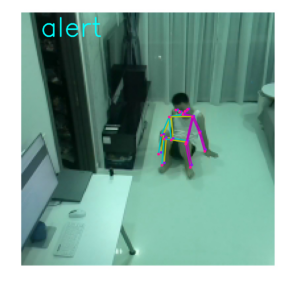

time: 969 ms (started: 2023-04-09 18:48:40 +08:00)


In [17]:
show_output_overlay(data, file=sample_file, label=sample_label, figsize=(5, 5))